<img src="https://github.com/djp840/MSDS_453_Public/blob/main/images/NorthwesternHeader.png?raw=1">

## MSDS453 - Research Assignment 03 - Ontology Plus Context and Modeling

Take the ontology that you developed in week 6 and consider how your ten chosen documents for this quarter's class corpus map to that ontology.

Protégé is a tool that takes inputs for a human-created Ontology and creates a visualization. 

Use Python algorithms to generate Knowledge Graphs from your documents.

TensorFlow Bidirectional RNN Model

In [1]:
import re
import string
import nltk
import gensim
import spacy

import pandas as pd
import numpy as np

import networkx as nx

import seaborn as sns
import matplotlib.pyplot as plt

from collections import Counter
from dataclasses import dataclass
from timeit import default_timer as timer

from nltk.corpus import stopwords
from nltk.stem.wordnet import WordNetLemmatizer
from nltk.tokenize import word_tokenize 

from gensim.models import Word2Vec

from spacy import displacy
from spacy.matcher import Matcher 
from spacy.tokens import Span 

from tqdm import tqdm

from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score, f1_score
from sklearn.model_selection import train_test_split

from IPython.display import display, HTML

from sklearn.metrics import confusion_matrix, classification_report
from sklearn.metrics import accuracy_score, f1_score

import tensorflow as tf
import tensorflow_datasets as tfds
from tensorflow import keras

from typing import List, Callable, Dict, Tuple, Set

In [2]:
tf.random.set_seed(2022)

<div class="alert alert-block alert-danger">
<b>Required Installation: en_core_web_lg</b><br>"python -m spacy download en_core_web_lg"<br><br>English pipeline optimized for CPU. Components: tok2vec, tagger, parser, senter, ner, attribute_ruler, lemmatizer<br>
    <b>https://spacy.io/models/en#en_core_web_lg </b>
</div>

In [3]:
import spacy.cli

spacy.cli.download("en_core_web_lg")

✔ Download and installation successful
You can now load the model via spacy.load('en_core_web_lg')


In [4]:
nlp = spacy.load('en_core_web_lg')

### Mount Google Drive to Colab Environment

In [5]:
#from google.colab import drive
#drive.mount('/content/gdrive')

### NLTK Downloads

In [6]:
# Only run this once, they will be downloaded.
nltk.download('stopwords',quiet=True)
nltk.download('wordnet',quiet=True)
nltk.download('punkt',quiet=True)
nltk.download('omw-1.4',quiet=True)

True

<div class="alert alert-block alert-danger">
<b>Gensim</b> is a Python library for topic modelling, document indexing and similarity retrieval with large corpora. Target audience is the natural language processing (NLP) and information retrieval (IR) community <br><br>
    <b>https://pypi.org/project/gensim/ </b>
</div>

In [7]:
import pkg_resources
pkg_resources.require("gensim<=3.8.3");

In [8]:
print("Genism Version: ", gensim.__version__)

Genism Version:  3.6.0


<div class="alert alert-block alert-info">
    <b>Suppress warning messages</b></div>

In [9]:
def warn(*args, **kwargs):
    pass
import warnings
warnings.warn = warn

## Data Wrangling Utility Functions

In [10]:
def add_movie_descriptor(data: pd.DataFrame, corpus_df: pd.DataFrame):
    """
    Adds "Movie Description" to the supplied dataframe, in the form {Genre}_{P|N}_{Movie Title}_{DocID}
    """
    review = np.where(corpus_df['ReviewType'] == 'Positive', 'P', 'N')

    data['Descriptor'] = corpus_df['Genre'] + '_' + \
                         corpus_df['MovieTitle'] + '_' + \
                         review + '_' + \
                         corpus_df['FileName'].astype(str)
    
def get_corpus_df(path: str) -> pd.DataFrame:
    data = pd.read_csv(path)
    add_movie_descriptor(data, data)
    sorted_data = data.sort_values(['Descriptor'])
    indexed_data = sorted_data.set_index(['FileName'])
    indexed_data['Doc_ID'] = indexed_data.index
    return indexed_data

def remove_punctuation(text):
    return re.sub('[^a-zA-Z]', ' ', str(text))

def remove_tags(text):    
    return re.sub("&lt;/?.*?&gt;"," &lt;&gt; ", text)
    
def remove_special_chars_and_digits(text):
    return re.sub("(\\d|\\W)+"," ", text)

def get_sentences(text: str) -> List[str]:
    return [str(x) for x in nlp(text).sents]

def get_coref_resolved_sentences(text: str) -> List[str]:
    return [str(x) for x in nlp(text).sents]

def get_lemmas(text: str, stopwords: Set[str]) -> List[str]:
    initial = [remove_tags(remove_special_chars_and_digits(remove_punctuation(x.lemma_.lower()))) for x in nlp(text)]
    return [x for x in initial if x not in stopwords]

def lemmatize_sentence(text: str, stopwords: Set[str]) -> str:
    return ' '.join(get_lemmas(text, stopwords))

def clean_doc(doc): 
    #doc = remove_punctuation(doc)
    doc= ' '.join(remove_stop_words(doc))
    doc = apply_lemmatization(doc)
    return doc

def remove_stop_words(in_text):
    stop_words = set(stopwords.words('english')) 
    word_tokens = word_tokenize(in_text)  
    filtered_sentence = [w for w in word_tokens if not w in stop_words] 
    return filtered_sentence

def apply_lemmatization(in_text):
    # Lemmatization
    lem = WordNetLemmatizer()
    word_list = nltk.word_tokenize(in_text)
    output = ' '.join([lem.lemmatize(w) for w in word_list])
    return output

def counter_word(text):
  count=Counter()
  for i in text.values:
    for word in i.split():
      count[word]=+1
  return count

def map_edges(map_to: str, map_from: Set[str], df: pd.DataFrame):
    print(f'Before mapping {", ".join(map_from)} -> {map_to}: {sum(df.edge == map_to)}')
    df['edge'] = np.where(kg_df.edge.isin(map_from), map_to, kg_df.edge)
    print(f'After mapping {", ".join(map_from)} -> {map_to}: {sum(df.edge == map_to)}')
    
def map_sources_and_targets(map_to: str, map_from: Set[str], df: pd.DataFrame):
    before = sum(df.source == map_to) + sum(df.target == map_to)
    print(f'Before mapping {", ".join(map_from)} -> {map_to}: {before}')
    
    df['source'] = np.where(kg_df.source.isin(map_from), map_to, kg_df.source)
    df['target'] = np.where(kg_df.target.isin(map_from), map_to, kg_df.target)
    
    after = sum(df.source == map_to) + sum(df.target == map_to)
    print(f'After mapping {", ".join(map_from)} -> {map_to}: {after}')
    
def get_neighborhood(sources: Set[str], edge_types: Set[str], depth: int, df: pd.DataFrame) -> pd.DataFrame:
    output = []
    
    for d in range(depth):
        if edge_types is not None:
            rows = df[(df.edge.isin(edge_types)) & ((df.source.isin(sources)) | (df.target.isin(sources)))].copy()
        else:
            rows = df[(df.source.isin(sources)) | (df.target.isin(sources))].copy()
            
        output.append(rows)
        sources = set(rows.target).union(set(rows.source))
        
    return pd.concat(output).drop_duplicates()

def find_sources_and_targets_with_patterns(patterns: List[str], df: pd.DataFrame):
    mask = np.zeros(kg_df.shape[0])
    for pattern in patterns:
        mask = mask | (df.source.str.contains(pattern)) | (df.target.str.contains(pattern))
        
    return df[mask]

def plot_graph(df: pd.DataFrame, show_edges: bool = False, figsize: Tuple[int, int] = (12, 12), use_circular: bool=True):
    graph = nx.from_pandas_edgelist(df, "source", "target", edge_attr='edge', create_using=nx.MultiDiGraph())

    plt.figure(figsize=figsize)
    if use_circular:
        pos = nx.circular_layout(graph)
    else:
        pos = nx.kamada_kawai_layout(graph)
        
    nx.draw(graph, with_labels=True, node_color='skyblue', edge_cmap=plt.cm.Blues, pos=pos)
    if show_edges:
        nx.draw_networkx_edge_labels(graph, pos=pos, font_size=8)
        
    plt.show()
    
def get_top_sources_and_targets(df: pd.DataFrame, top: int = 10):
    return (Counter(df.source) + Counter(df.target)).most_common(top)

def get_top_edges(df: pd.DataFrame, top: int = 10):
    return Counter(df.edge).most_common(top)

def get_dataset_partitions_pd(df, train_split=0.8, val_split=0.10, test_split=0.10):
       # Specify seed to always have the same split distribution between runs
    df_sample = df.sample(frac=1, random_state=12)
    indices_or_sections = [int(.8*len(df)), int(.9*len(df))]
    train_ds, val_ds, test_ds = np.split(df_sample, indices_or_sections)
    return train_ds, val_ds, test_ds

## Entity Extraction Functions

In [11]:
def get_entities(sent):
  ## chunk 1
  ent1 = ""
  ent2 = ""

  prv_tok_dep = ""    # dependency tag of previous token in the sentence
  prv_tok_text = ""   # previous token in the sentence

  prefix = ""
  modifier = ""

  for tok in nlp(sent):
    ## chunk 2
    # if token is a punctuation mark then move on to the next token
    if tok.dep_ != "punct":
      # check: token is a compound word or not
      if tok.dep_ == "compound":
        prefix = tok.text
        # if the previous word was also a 'compound' then add the current word to it
        if prv_tok_dep == "compound":
          prefix = prv_tok_text + " "+ tok.text
      
      # check: token is a modifier or not
      if tok.dep_.endswith("mod") == True:
        modifier = tok.text
        # if the previous word was also a 'compound' then add the current word to it
        if prv_tok_dep == "compound":
          modifier = prv_tok_text + " "+ tok.text
      
      ## chunk 3
      if tok.dep_.find("subj") == True:
        ent1 = modifier +" "+ prefix + " "+ tok.text
        prefix = ""
        modifier = ""
        prv_tok_dep = ""
        prv_tok_text = ""      

      ## chunk 4
      if tok.dep_.find("obj") == True:
        ent2 = modifier +" "+ prefix +" "+ tok.text
        
      ## chunk 5  
      # update variables
      prv_tok_dep = tok.dep_
      prv_tok_text = tok.text

  return [ent1.strip(), ent2.strip()]

def get_relation(sent):
    try:
        doc = nlp(sent)
        
        # Matcher class object 
        matcher = Matcher(nlp.vocab)

        #define the pattern 
        pattern = [{'DEP':'ROOT'}, 
                {'DEP':'prep','OP':"?"},
                {'DEP':'agent','OP':"?"},  
                {'POS':'ADJ','OP':"?"}] 
        matcher.add("matching_1", [pattern]) 
        matches = matcher(doc)
        k = len(matches) - 1
        span = doc[matches[k][1]:matches[k][2]] 
        
        return(span.text)
    except:
        pass
    
def get_subject_verb_object(sent):
  ent1 = ""
  ent2 = ""
  root = ""

  for tok in nlp(sent):
      if tok.dep_ == 'ROOT':
        root = tok.text
      elif tok.dep_ == "nsubj":
        ent1 = tok.text
      elif tok.dep_ == "dobj":
        ent2 = tok.text

      if ent1 != '' and ent2 != '' and root != '':
        break

  return [ent1, root, ent2]

## Visualization Utility Functions

In [12]:
def plot_confusion_matrix_labeled(y_true, y_pred, CLASSES_LIST):
    mtx = confusion_matrix(y_true, y_pred)
    # define classes 
    classes = CLASSES_LIST
    temp_df = pd.DataFrame(data=mtx,columns=classes)
    temp_df.index = classes
    fig, ax = plt.subplots(figsize=(10,10))
    sns.heatmap(temp_df, annot=True, fmt='d', linewidths=.75,  cbar=False, ax=ax,cmap='Blues',linecolor='white')
    #  square=True,
    plt.ylabel('true label')
    plt.xlabel('predicted label')
    
def plot_graphs(history, metric):
  plt.plot(history.history[metric])
  plt.plot(history.history['val_'+metric], '')
  plt.xlabel("Epochs")
  plt.ylabel(metric)
  plt.legend([metric, 'val_'+metric])

## Loading the Class Corpus

In [13]:
CORPUS_PATH = '/content/ClassCorpus_V2.csv'

In [14]:
corpus_df = get_corpus_df(CORPUS_PATH)

In [15]:
corpus_df.shape

(190, 7)

## Exploratory Data Analysis

In [16]:
# Tokenize sentences
corpus_df['raw_sentences'] = corpus_df.MovieReview.apply(get_sentences)

In [17]:
corpus_df.head(3)

,StudentName,Genre,ReviewType,MovieTitle,MovieReview,Descriptor,Doc_ID,raw_sentences
FileName,,,,,,,,
SSM_Doc10_BabyDriver,SSM,Action,Negative,Baby Driver,"Getaway driver Baby (Ansel Elgort, The Diverge...",Action_Baby Driver_N_SSM_Doc10_BabyDriver,SSM_Doc10_BabyDriver,"[Getaway driver Baby (Ansel Elgort, The Diverg..."
SSM_Doc6_BabyDriver,SSM,Action,Negative,Baby Driver,BABY DRIVER is quite frustrating because the d...,Action_Baby Driver_N_SSM_Doc6_BabyDriver,SSM_Doc6_BabyDriver,[BABY DRIVER is quite frustrating because the ...
SSM_Doc7_BabyDriver,SSM,Action,Negative,Baby Driver,"The star, ace getaway driver Baby (Ansel Elgor...",Action_Baby Driver_N_SSM_Doc7_BabyDriver,SSM_Doc7_BabyDriver,"[The star, ace getaway driver Baby (Ansel Elgo..."


In [18]:
corpus_df.MovieTitle.value_counts()

Baby Driver                                               10
Hereditary                                                10
The Martian                                               10
Interstellar                                              10
Arrival                                                   10
Us                                                        10
The Ring                                                  10
The Conjuring 3                                           10
IT                                                        10
Spider Man 3                                              10
James Bond Casino Royale                                  10
Red Notice                                                10
Once upon a time in Hollywood                             10
Frozen II                                                 10
Cruella                                                   10
Speed racer                                               10
Pirates of the Carribean

In [19]:
# Tokenize words
default_stopwords = (set(nltk.corpus.stopwords.words('english')).union(set(nlp.Defaults.stop_words))
                                                                .union({' ', ''}))

In [20]:
corpus_df['lemmas'] = corpus_df.MovieReview.apply(lambda x: get_lemmas(x, default_stopwords))
corpus_df.lemmas.head()

FileName
SSM_Doc10_BabyDriver    [getaway, driver, baby, ansel, elgort, diverge...
SSM_Doc6_BabyDriver     [baby, driver, frustrating, driving, scene, im...
SSM_Doc7_BabyDriver     [star, ace, getaway, driver, baby, ansel, elgo...
SSM_Doc8_BabyDriver     [edgar, wright, action, movie, mode, baby, dri...
SSM_Doc9_BabyDriver     [thank, error, judgment, baby, main, character...
Name: lemmas, dtype: object

In [21]:
# Reassemble lemmas
corpus_df['lemmas_joined'] = corpus_df.lemmas.apply(lambda x: ' '.join(x))

In [22]:
# Generate a set of additional words to remove by DF
vectorizer = CountVectorizer(ngram_range=(1, 1))
transformed_documents = vectorizer.fit_transform(corpus_df.lemmas_joined)
doc_term_matrix = transformed_documents.todense()
doc_term_df = pd.DataFrame(doc_term_matrix, 
                           columns=vectorizer.get_feature_names_out(), 
                           index=corpus_df.Descriptor)
print(f'Vocabulary size: {doc_term_df.shape[1]}')
all_words = set(doc_term_df.columns)

vectorizer = CountVectorizer(ngram_range=(1, 1), min_df=5, max_df=.8)
transformed_documents = vectorizer.fit_transform(corpus_df.lemmas_joined)
doc_term_matrix = transformed_documents.todense()
doc_term_df = pd.DataFrame(doc_term_matrix, 
                           columns=vectorizer.get_feature_names_out(), 
                           index=corpus_df.Descriptor)
print(f'Vocabulary size: {doc_term_df.shape[1]}')
vocabulary = set(doc_term_df.columns)

words_to_remove = default_stopwords.union(all_words - vocabulary)

Vocabulary size: 11797
Vocabulary size: 2577


Text(0, 0.5, 'Number of Terms')

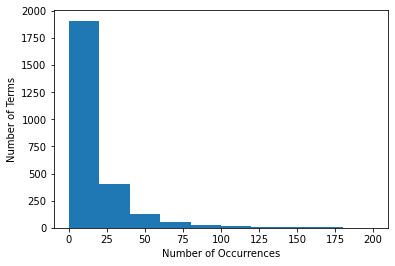

In [23]:
plt.hist(doc_term_df.sum(axis=0).T, range=(0, 200))
plt.xlabel('Number of Occurrences')
plt.ylabel('Number of Terms')

In [24]:
# Re-tokenize words, recreate joined documents
corpus_df['lemmas'] = corpus_df.MovieReview.apply(lambda x: get_lemmas(x, words_to_remove))
corpus_df['lemmas_joined'] = corpus_df.lemmas.apply(lambda x: ' '.join(x))
corpus_df.lemmas.head()

FileName
SSM_Doc10_BabyDriver    [getaway, driver, baby, ansel, elgort, series,...
SSM_Doc6_BabyDriver     [baby, driver, scene, shoot,  pron , feature, ...
SSM_Doc7_BabyDriver     [star, getaway, driver, baby, ansel, elgort, w...
SSM_Doc8_BabyDriver     [edgar, wright, action, movie, mode, baby, dri...
SSM_Doc9_BabyDriver     [thank, baby, main, character, new, thriller, ...
Name: lemmas, dtype: object

In [25]:
# Get lemmatized and filtered sentences
corpus_df['sentences_lemmatized'] = corpus_df.raw_sentences.apply(lambda x: [lemmatize_sentence(s, words_to_remove) for s in x])

## Review Documents By Movie Title

In [26]:
print(corpus_df['MovieTitle'].unique())

['Baby Driver' 'James Bond Casino Royale' 'Mission Impossible Fallout'
 'Pirates of the Carribean: The Curse of the Black Pearl' 'Speed racer'
 'Cruella' 'Frozen II' 'Once upon a time in Hollywood' 'Red Notice'
 'Spider Man 3' 'Hereditary' 'IT' 'The Conjuring 3' 'The Ring' 'Us'
 'Arrival' 'Interstellar' 'The Martian' 'The Matrix Resurrections']


In [27]:
movie_df = corpus_df[corpus_df['MovieTitle'] == 'Cruella'].copy()
movie_df.head(3).T

FileName,PHQ_Doc10_Cruella,PHQ_Doc1_Cruella,PHQ_Doc4_Cruella
StudentName,PHQ,PHQ,PHQ
Genre,Comedy,Comedy,Comedy
ReviewType,Negative,Negative,Negative
MovieTitle,Cruella,Cruella,Cruella
MovieReview,Craig Gillespies Cruella explores the backstor...,"Did you ever wonder how Cruella De Vil, the va...",With her shock of black-and-white hair and cri...
Descriptor,Comedy_Cruella_N_PHQ_Doc10_Cruella,Comedy_Cruella_N_PHQ_Doc1_Cruella,Comedy_Cruella_N_PHQ_Doc4_Cruella
Doc_ID,PHQ_Doc10_Cruella,PHQ_Doc1_Cruella,PHQ_Doc4_Cruella
raw_sentences,[Craig Gillespies Cruella explores the backsto...,"[Did you ever wonder how Cruella De Vil, the v...",[With her shock of black-and-white hair and cr...
lemmas,"[craig, cruella, explore, backstory, cruella, ...","[ pron , wonder, cruella, de, vil, disney, s,...","[ pron , shock, black, white, hair, color, cru..."
lemmas_joined,craig cruella explore backstory cruella debut ...,pron wonder cruella de vil disney s dalmati...,pron shock black white hair color cruella de...


## Knowledge Graph Extraction

In [28]:
corpus_text_sentences = [y for x in movie_df.raw_sentences for y in x]
example_sentence = nlp(corpus_text_sentences[1])
corpus_text_sentences[1]

'101 Dalmatians and was played by Glenn Close in its 1996 live-action remake.'

In [29]:
entity_pairs = [get_entities(x) for x in tqdm(corpus_text_sentences)]

100%|██████████| 435/435 [00:05<00:00, 85.66it/s]


### Create DataFrame (Source, Target, Edge)

In [30]:
relations = [get_relation(x) for x in corpus_text_sentences]   
#extract subject and object
source = [i[0] for i in entity_pairs]
target = [i[1] for i in entity_pairs]
exp1_df = kg_df = pd.DataFrame({'source': source, 'target': target, 'edge': relations})

### Knowledge Graph Preprocessing (Lowercase, Remove Empty Spaces)

In [31]:
# Move everything to lower case
kg_df.source = kg_df.source.str.lower()
kg_df.target = kg_df.target.str.lower()
kg_df.edge = kg_df.edge.str.lower()

# Filter out empties
kg_df = kg_df[kg_df.source != '']
kg_df = kg_df[kg_df.target != '']
kg_df = kg_df[kg_df.edge != ''].copy()

In [32]:
kg_df.head(9).T

,0,2,3,5,6,7,8,10,11
source,be dalmatian who,arch emma stone,intellectual that,novelistic gillespies film,nice camp girlthat,how rabbit hole,baronesss,first act,individual her
target,animated 1961s,eponymous role,recently disneys maleficent movies,inhuman animal antagonist,new movie universe,20 years,formative bte noire,backstorys backstory,private school
edge,explores,goes from colorful,film,takes,is,wonder,get,establishes,accompanies


In [33]:
len(corpus_text_sentences)

435

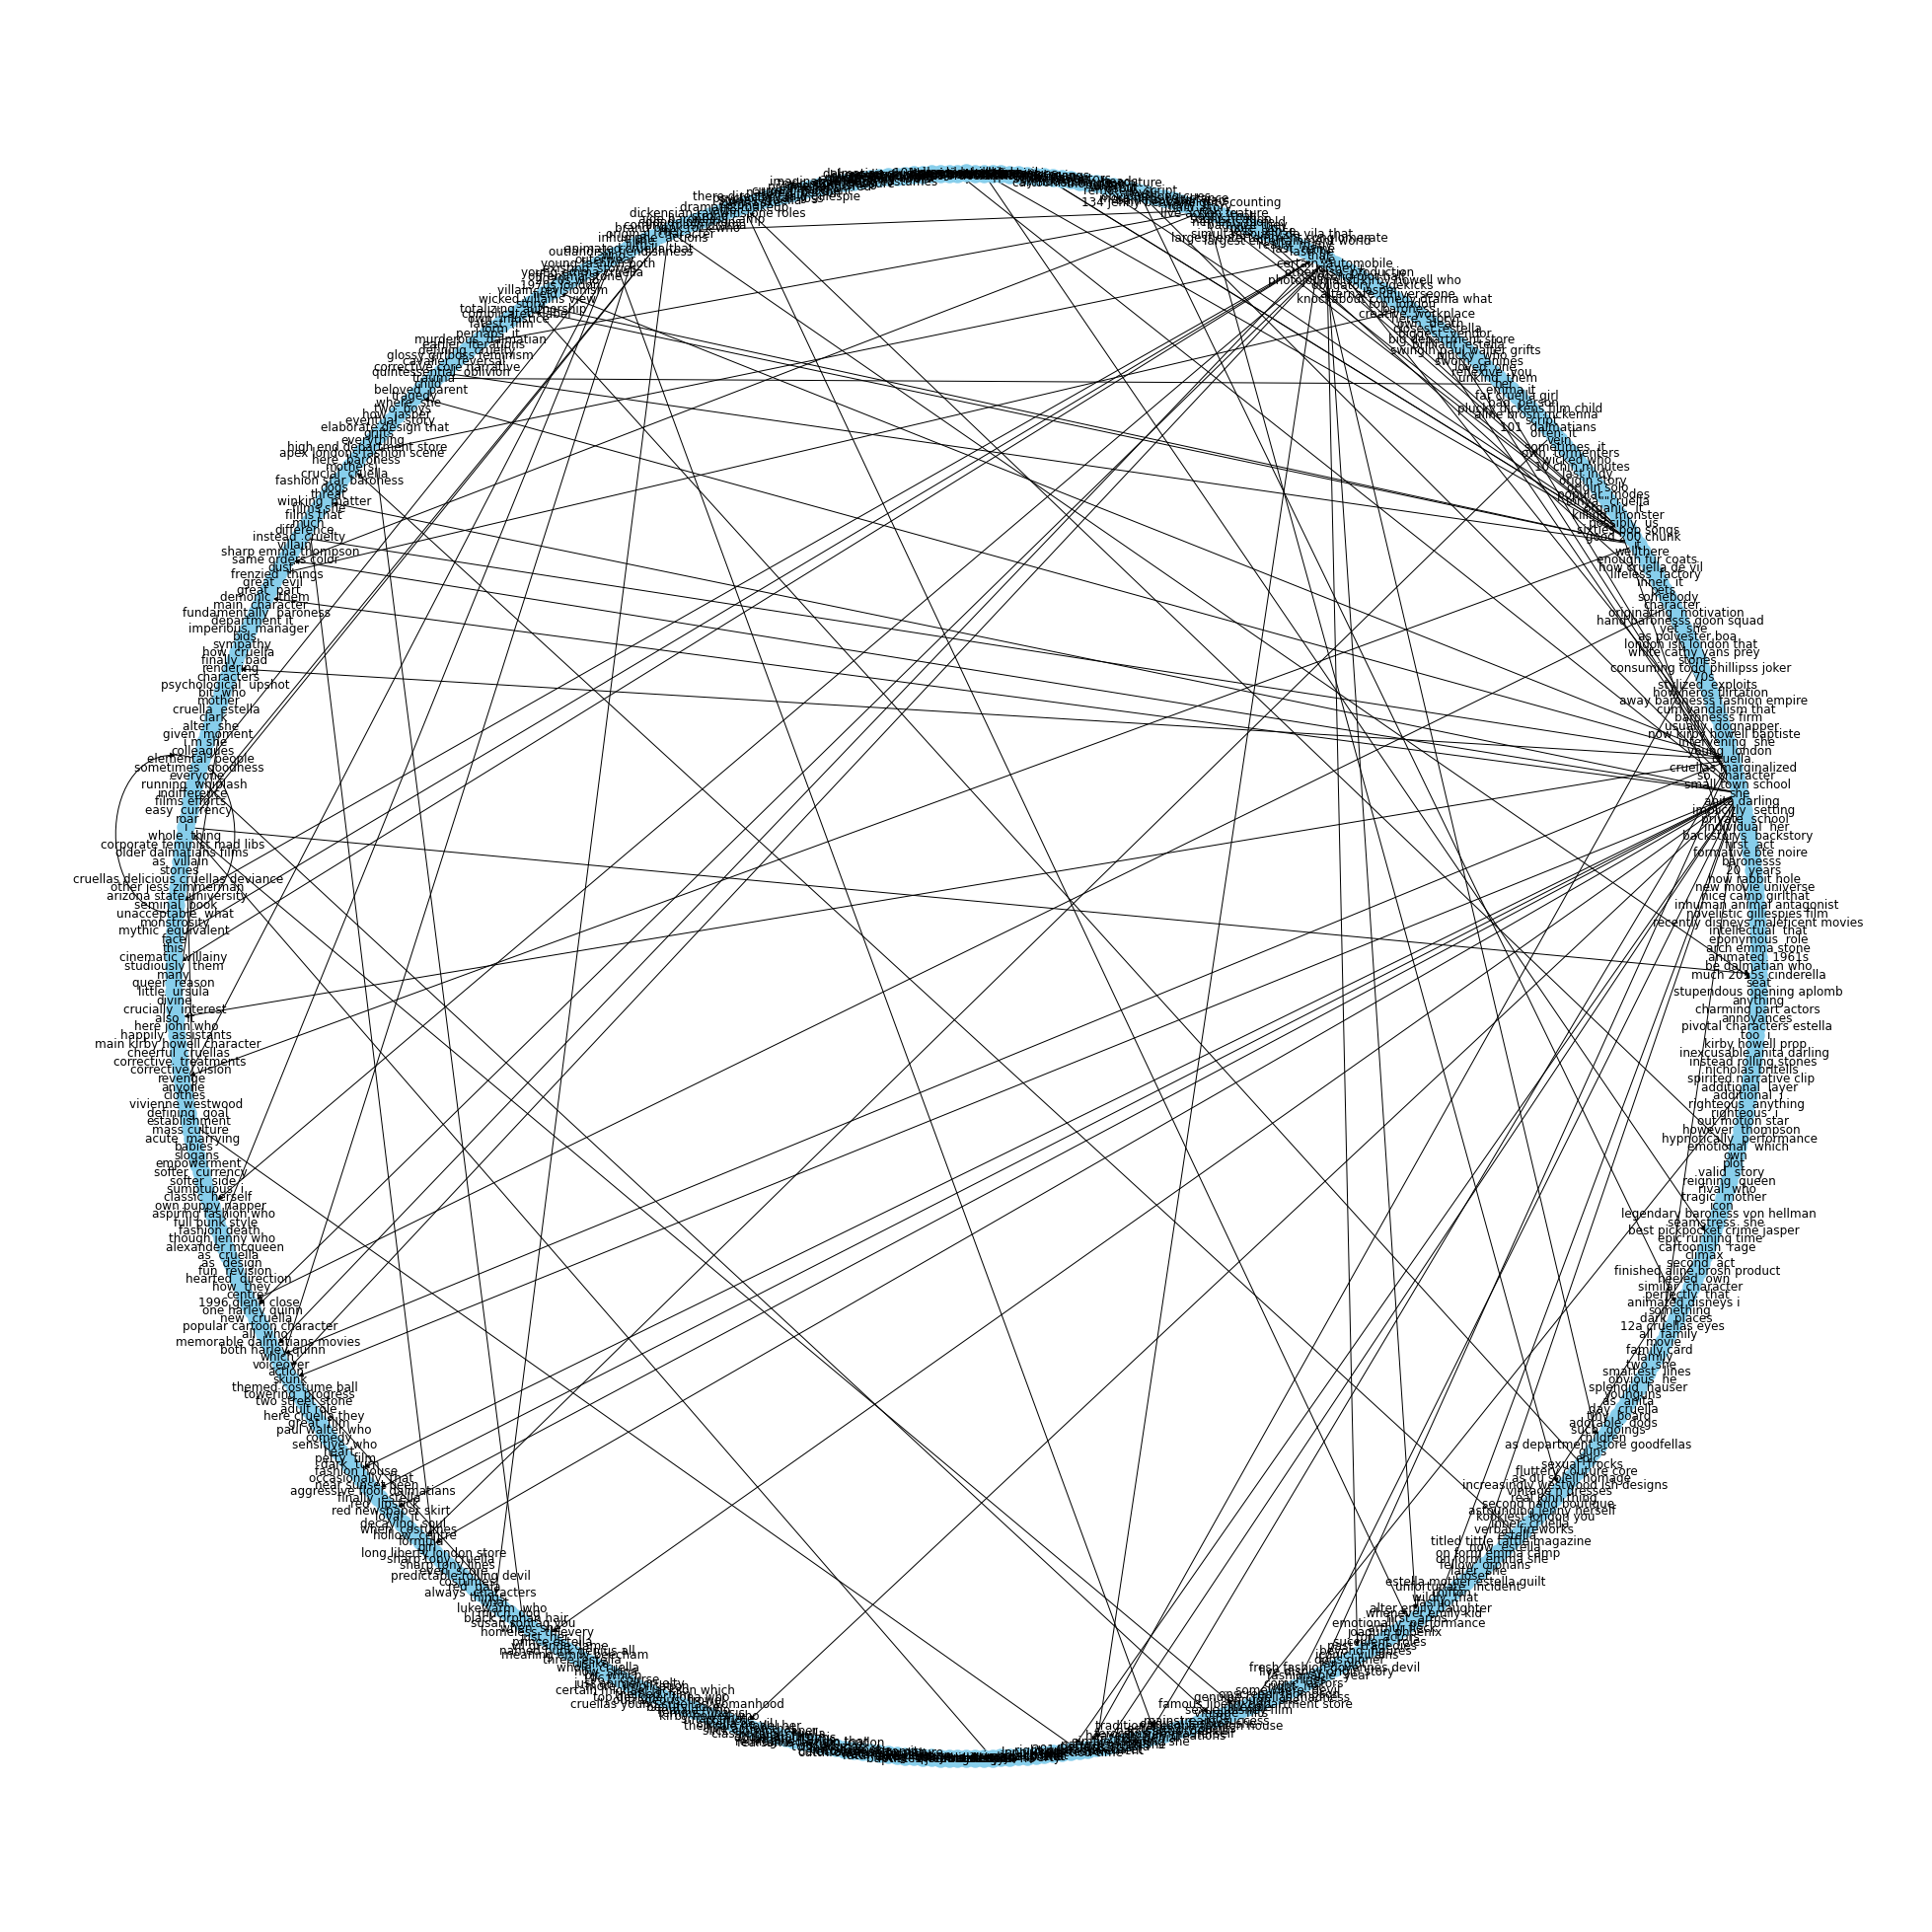

In [34]:
plot_graph(kg_df, figsize=(27, 27), use_circular=True)

## Recurrent Neural Network (RNN) Model Development

<img src="https://github.com/djp840/MSDS_453_Public/blob/main/images/BidirectionalRNN.png?raw=true">

<div class="alert alert-block alert-info">
    <b>tf.keras.layers.Bidirectional</b><br>
    https://www.tensorflow.org/api_docs/python/tf/keras/layers/Bidirectional
    </div>

In [35]:
datafull = corpus_df.copy() 
datafull.reset_index(drop=True, inplace=True)
datafull.head().T

,0,1,2,3,4
StudentName,SSM,SSM,SSM,SSM,SSM
Genre,Action,Action,Action,Action,Action
ReviewType,Negative,Negative,Negative,Negative,Negative
MovieTitle,Baby Driver,Baby Driver,Baby Driver,Baby Driver,Baby Driver
MovieReview,"Getaway driver Baby (Ansel Elgort, The Diverge...",BABY DRIVER is quite frustrating because the d...,"The star, ace getaway driver Baby (Ansel Elgor...",Edgar Wright is back in action movie mode for ...,"Thanks to an error in judgment, Baby (the main..."
Descriptor,Action_Baby Driver_N_SSM_Doc10_BabyDriver,Action_Baby Driver_N_SSM_Doc6_BabyDriver,Action_Baby Driver_N_SSM_Doc7_BabyDriver,Action_Baby Driver_N_SSM_Doc8_BabyDriver,Action_Baby Driver_N_SSM_Doc9_BabyDriver
Doc_ID,SSM_Doc10_BabyDriver,SSM_Doc6_BabyDriver,SSM_Doc7_BabyDriver,SSM_Doc8_BabyDriver,SSM_Doc9_BabyDriver
raw_sentences,"[Getaway driver Baby (Ansel Elgort, The Diverg...",[BABY DRIVER is quite frustrating because the ...,"[The star, ace getaway driver Baby (Ansel Elgo...",[Edgar Wright is back in action movie mode for...,"[Thanks to an error in judgment, Baby (the mai..."
lemmas,"[getaway, driver, baby, ansel, elgort, series,...","[baby, driver, scene, shoot, pron , feature, ...","[star, getaway, driver, baby, ansel, elgort, w...","[edgar, wright, action, movie, mode, baby, dri...","[thank, baby, main, character, new, thriller, ..."
lemmas_joined,getaway driver baby ansel elgort series job do...,baby driver scene shoot pron feature cool ca...,star getaway driver baby ansel elgort wait whe...,edgar wright action movie mode baby driver cri...,thank baby main character new thriller baby dr...


In [36]:
datafull['MovieReview'] = datafull['MovieReview'].apply(lambda x : clean_doc(x))

In [37]:
data = datafull[['MovieReview','Genre']].copy()

In [38]:
data['Genre'] = data['Genre'].astype("category")
data['Genre Code'] = data['Genre'].cat.codes
data['Genre Code'].tail().T

185    3
186    3
187    3
188    3
189    3
Name: Genre Code, dtype: int8

In [39]:
features, targets = data['MovieReview'], data['Genre Code']


In [40]:
train_features, test_features, train_targets, test_targets = train_test_split(features, 
                                                                              targets , 
                                                                              test_size=0.20, 
                                                                              random_state=42, 
                                                                              shuffle=True,
                                                                              stratify=targets)

In [41]:
data.head()

,MovieReview,Genre,Genre Code
0,"Getaway driver Baby ( Ansel Elgort , The Diver...",Action,0
1,BABY DRIVER quite frustrating driving scene im...,Action,0
2,"The star , ace getaway driver Baby ( Ansel Elg...",Action,0
3,Edgar Wright back action movie mode Baby Drive...,Action,0
4,"Thanks error judgment , Baby ( main character ...",Action,0


In [42]:
data[["Genre", "Genre Code"]].value_counts()

Genre   Genre Code
Action  0             50
Comedy  1             50
Horror  2             50
Sci-Fi  3             40
dtype: int64

## Create Datasets for Model Development

In [43]:
trainds, valds, testds = get_dataset_partitions_pd(data[['MovieReview','Genre Code']])
trainds.shape, valds.shape, testds.shape

((152, 2), (19, 2), (19, 2))

## Convert DataFrame to TensorFlow DataSet

In [44]:
# train X & y
train_text_ds_raw = tf.data.Dataset.from_tensor_slices(
            tf.cast(trainds['MovieReview'].values, tf.string)
) 
train_cat_ds_raw = tf.data.Dataset.from_tensor_slices(
            tf.cast(trainds['Genre Code'].values, tf.int64),
  ) 
# test X & y
test_text_ds_raw = tf.data.Dataset.from_tensor_slices(
            tf.cast(testds['MovieReview'].values, tf.string)
) 
test_cat_ds_raw = tf.data.Dataset.from_tensor_slices(
            tf.cast(testds['Genre Code'].values, tf.int64),
)
#val X & Y
val_text_ds_raw = tf.data.Dataset.from_tensor_slices(
            tf.cast(valds['MovieReview'].values, tf.string)
) 
val_cat_ds_raw = tf.data.Dataset.from_tensor_slices(
            tf.cast(valds['Genre Code'].values, tf.int64),
)

## Create DataSets (X=Preprocessed Text, Y=Encoded Categories)

In [45]:
train_ds = tf.data.Dataset.zip(
    (
            train_text_ds_raw,
            train_cat_ds_raw
     )
)
test_ds = tf.data.Dataset.zip(
    (
            test_text_ds_raw,
            test_cat_ds_raw
     )
)
val_ds = tf.data.Dataset.zip(
    (
            val_text_ds_raw,
            val_cat_ds_raw
     )
)

## Create Data Pipelines (Batching, Shuffling, and Optimizing)

In [46]:
batch_size = 3
AUTOTUNE = tf.data.experimental.AUTOTUNE
buffer_size = train_ds.cardinality().numpy()

train_ds = (train_ds.shuffle(buffer_size=buffer_size)
                    .batch(batch_size=batch_size,drop_remainder=True)
                    .cache()
                    .prefetch(AUTOTUNE))

test_ds = (test_ds.shuffle(buffer_size=buffer_size)
                  .batch(batch_size=batch_size,drop_remainder=True)
                  .cache()
                  .prefetch(AUTOTUNE))

val_ds = (val_ds.shuffle(buffer_size=buffer_size)
                .batch(batch_size=batch_size,drop_remainder=True)
                .cache()
                .prefetch(AUTOTUNE))

In [47]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 190 entries, 0 to 189
Data columns (total 3 columns):
 #   Column       Non-Null Count  Dtype   
---  ------       --------------  -----   
 0   MovieReview  190 non-null    object  
 1   Genre        190 non-null    category
 2   Genre Code   190 non-null    int8    
dtypes: category(1), int8(1), object(1)
memory usage: 2.2+ KB


## Create the Text Encoder

The raw text loaded by `tfds` needs to be processed before it can be used in a model. The simplest way to process text for training is using the `experimental.preprocessing.TextVectorization` layer. This layer has many capabilities, but this tutorial sticks to the default behavior.

Create the layer, and pass the dataset's text to the layer's `.adapt` method:
The processing of each sample contains the following steps:

    standardize each sample (usually lowercasing + punctuation stripping)
    split each sample into substrings (usually words)
    recombine substrings into tokens (usually ngrams)
    index tokens (associate a unique int value with each token)
    transform each sample using this index, either into a vector of ints or a dense float vector.

In [48]:
x_train = train_features.to_numpy()
y_train = train_targets.to_numpy()
x_test = test_features.to_numpy()
y_test = test_targets.to_numpy()

In [49]:
VOCAB_SIZE = 5000
encoder = tf.keras.layers.experimental.preprocessing.TextVectorization(
    max_tokens=VOCAB_SIZE, standardize="lower_and_strip_punctuation", pad_to_max_tokens= True)
encoder.adapt(train_ds.map(lambda text, label: text), batch_size= None)

In [50]:
vocab = np.array(encoder.get_vocabulary())
len(vocab)

5000

In [51]:
vocab = np.array(encoder.get_vocabulary())
vocab[:20]

array(['', '[UNK]', 'the', 'film', 's', 'movie', 'i', 'one', 'like', 'it',
       'character', 'time', 'bond', 'get', 'make', 'but', 'way', 'story',
       'nt', 'first'], dtype='<U20')

In [52]:
vocab[-20:]

array(['openhearted', 'online', 'ongoing', 'oneself', 'oneman',
       'onelastjob', 'onedimensional', 'ominously', 'omg', 'oleff',
       'olafs', 'offscreen', 'offputting', 'oddcouple', 'occurs', 'occur',
       'occasion', 'obsessivecompulsive', 'observation', 'obscure'],
      dtype='<U20')

## Example of Encoded Words

In [53]:
encoded_example = encoder('Encanto Nobody Talks About Buno').numpy()
encoded_example[:]

array([   1,    1,    1, 3153,    1])

In [54]:
len(encoder.get_vocabulary())

5000

In [55]:
encoder(data['MovieReview'][0])

<tf.Tensor: shape=(334,), dtype=int64, numpy=
array([ 923,  142,   66, 1448,  745,    2,    1,  109,    1,    7,  345,
        514, 1003,  972,    1,  316,    1,   44,  850,  175, 1548,  461,
        208,  131, 1873, 1415, 1365,  165, 3495, 4864,    1,  514,   14,
       2289,   66,  480, 1845,  145,   66,  383,  649, 1005,  852, 1004,
       3219,    1, 1595, 2435, 2049, 3239,  926,    1,    1, 3025, 2501,
       1751, 1126,  252, 1940, 2743, 1209,   66, 2196,  119, 1418,  696,
       3674,  138, 3003,   66,  142,   82,  315, 1845,   52, 4445,    1,
       1093,   27,  151,  276,    1,    3,  103,  315, 2783,  310, 2750,
         50,  577,    1,  205,   68,    1,  858,   58,  382,   66,   66,
       1298, 3957,  341,  229,   58,  737,  382,  294,  673,   66,   37,
        914, 2332,    3,   74, 1290, 3056,    1,  138,   14,  268,  169,
       2100,    1,  138,   24, 2269,   66,  142, 1718,  632, 1312, 2230,
         66,  142, 4553, 2508,  220,    1,    1,  276,  310,  283, 2453,
     

In [56]:
for example, label in train_ds.take(1):
  print('texts: ', example.numpy()[:1])
  print()

texts:  [b'Tom Cruise cinema greatest action star . Fortunately , hyperbolic claim without argument back . Around dawn last century , Douglas Fairbanks swashbuckled way fame climbing wall , riding horse , swinging rope title like The Mark Zorro ( 1920 ) Robin Hood ( 1922 ) . Although Fairbanks accomplished gymnast , eventually conceded use stunt double daring feat . After Fairbanks , Errol Flynn took crown , shot arrow performed dangerous sword fight The Adventures Robin Hood ( 1938 ) The Sea Hawk ( 1940 ) . In subsequent decade , actor including Tyrone Power , Bruce Lee , Harrison Ford , Sylvester Stallone , Arnold Schwarzenegger , others became action icon , could actually perform exploit character instead relied talent stunt worker . Perhaps skill evident onscreen , martial artist dominated cinematic bravado recent decade , allowing Jackie Chan Jason Statham impress ability carry elaborately choreographed fight . But many actor , Fairbanks Chan , tied side plane ? How many driven to

## Build RNN Sequential Model 

<div class="alert alert-block alert-info">
    <b>Module: tf.keras.layers</b><br>
    https://www.tensorflow.org/api_docs/python/tf/keras/layers
    </div>

In [57]:
num_classes = 4

In [58]:
model = tf.keras.Sequential([encoder,
                             tf.keras.layers.Embedding(len(encoder.get_vocabulary()), 64, mask_zero=True),
                             tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(64,  return_sequences=True, dropout=0.3)),
                             tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(32, dropout=0.3)),
                             tf.keras.layers.Dense(64, activation='relu'),
                             tf.keras.layers.Dense(num_classes, activation='softmax')])

In [59]:
model.compile(optimizer= tf.keras.optimizers.Adam(),
              loss=tf.keras.losses.SparseCategoricalCrossentropy(),
              metrics=['accuracy'])

In [60]:
%%time
history = model.fit(train_ds,
                    epochs=200,
                    validation_data=val_ds,
                    validation_steps=3,
                    callbacks=[tf.keras.callbacks.EarlyStopping(monitor='val_accuracy', patience=3)])

Epoch 1/200
50/50 [==============================] - 82s 1s/step - loss: 1.3881 - accuracy: 0.2133 - val_loss: 1.4057 - val_accuracy: 0.1111
Epoch 2/200
50/50 [==============================] - 56s 1s/step - loss: 1.2770 - accuracy: 0.4267 - val_loss: 1.2847 - val_accuracy: 0.3333
Epoch 3/200
50/50 [==============================] - 56s 1s/step - loss: 0.7868 - accuracy: 0.7533 - val_loss: 1.6690 - val_accuracy: 0.5556
Epoch 4/200
50/50 [==============================] - 56s 1s/step - loss: 0.5321 - accuracy: 0.7733 - val_loss: 0.8895 - val_accuracy: 0.5556
Epoch 5/200
50/50 [==============================] - 56s 1s/step - loss: 0.1394 - accuracy: 0.9733 - val_loss: 2.0050 - val_accuracy: 0.4444
Epoch 6/200
50/50 [==============================] - 56s 1s/step - loss: 0.0293 - accuracy: 1.0000 - val_loss: 1.9076 - val_accuracy: 0.4444
CPU times: user 11min 17s, sys: 4.35 s, total: 11min 21s
Wall time: 7min 36s


## Model Performance Test Accuracy

In [61]:
test_loss, test_acc = model.evaluate(val_ds)

print('Test Loss: {}'.format(test_loss))
print('Test Accuracy: {}'.format(test_acc))

6/6 [==============================] - 1s 186ms/step - loss: 2.1421 - accuracy: 0.3889
Test Loss: 2.1421315670013428
Test Accuracy: 0.3888888955116272


## Plotting Performance Metrics - Multi-Layer Bidirectional RNN

In [62]:
history_dict = history.history
history_dict.keys()

dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy'])

In [63]:
history_df = pd.DataFrame(history_dict)
history_df.tail().round(3)

,loss,accuracy,val_loss,val_accuracy
1,1.277,0.427,1.285,0.333
2,0.787,0.753,1.669,0.556
3,0.532,0.773,0.889,0.556
4,0.139,0.973,2.005,0.444
5,0.029,1.000,1.908,0.444


In [64]:
losses = history.history['loss']
accs = history.history['accuracy']
val_losses = history.history['val_loss']
val_accs = history.history['val_accuracy']
epochs = len(losses)

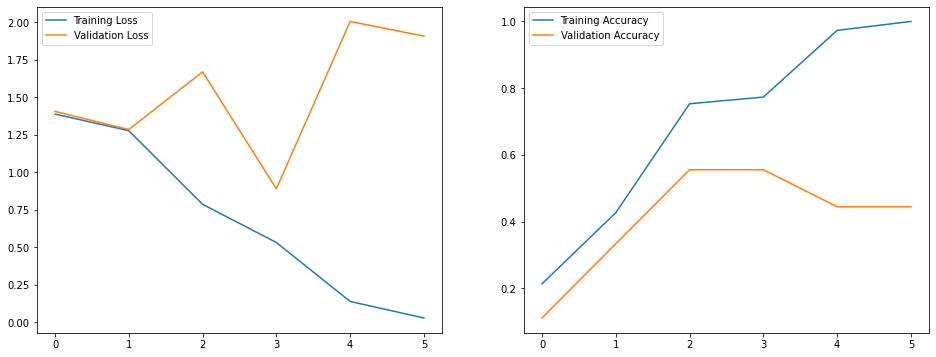

In [65]:
plt.figure(figsize=(16, 6))
for i, metrics in enumerate(zip([losses, accs], [val_losses, val_accs], ['Loss', 'Accuracy'])):
    plt.subplot(1, 2, i + 1)
    plt.plot(range(epochs), metrics[0], label='Training {}'.format(metrics[2]))
    plt.plot(range(epochs), metrics[1], label='Validation {}'.format(metrics[2]))
    plt.legend()
plt.show()

## Confusion Matrix Post Model Performance Analysis

In [66]:
preds2 = model.predict(test_ds)
y_pred2 = np.argmax(preds2, axis=1)
y2 = np.concatenate([y for x, y in test_ds], axis=0)

In [67]:
CLASSES_LIST = ['Action', 'Comedy', 'Horror', 'Sci-Fi']

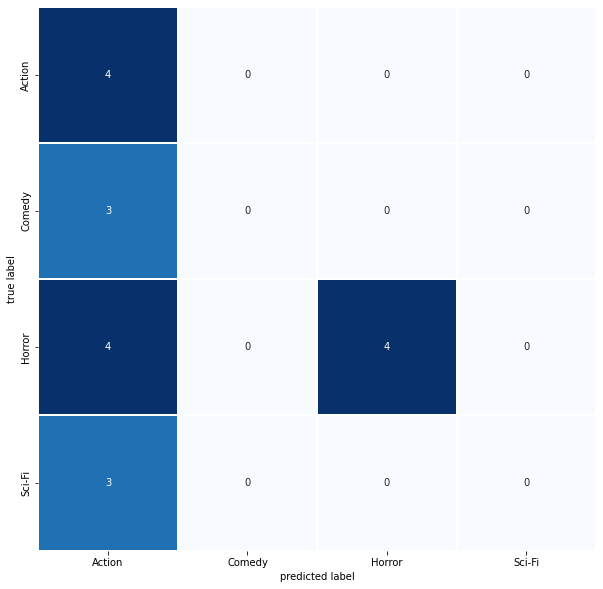

In [68]:
plot_confusion_matrix_labeled(y2, y_pred2, CLASSES_LIST=CLASSES_LIST)

In [69]:
cm = sns.light_palette((260, 75, 60), input="husl", as_cmap=True)

In [70]:
df2 = pd.DataFrame(preds2[0:15], columns = CLASSES_LIST).T

In [71]:
df2.style.format("{:.2%}").background_gradient(cmap=cm)

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14
Action,41.04%,98.61%,97.57%,71.06%,35.09%,98.15%,71.52%,97.77%,91.86%,97.89%,6.23%,97.77%,98.07%,96.86%,91.52%
Comedy,1.38%,0.41%,0.27%,0.26%,0.32%,0.23%,20.59%,0.35%,0.31%,0.95%,0.28%,0.87%,0.47%,0.90%,0.23%
Horror,56.87%,0.97%,2.15%,28.66%,64.46%,1.61%,1.13%,1.87%,7.80%,1.14%,92.76%,1.34%,1.45%,2.21%,8.25%
Sci-Fi,0.71%,0.01%,0.01%,0.02%,0.14%,0.00%,6.76%,0.01%,0.03%,0.02%,0.74%,0.02%,0.01%,0.04%,0.01%


## RNN Model Architecture

In [72]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 text_vectorization (TextVec  (None, None)             0         
 torization)                                                     
                                                                 
 embedding (Embedding)       (None, None, 64)          320000    
                                                                 
 bidirectional (Bidirectiona  (None, None, 128)        66048     
 l)                                                              
                                                                 
 bidirectional_1 (Bidirectio  (None, 64)               41216     
 nal)                                                            
                                                                 
 dense (Dense)               (None, 64)                4160      
                                                        